In [1]:
from jax import jit, value_and_grad
import numpy as np
from qiskit_dynamics.array import wrap, Array
from qiskit_dynamics.pulse import InstructionToSignals
from scipy.optimize import minimize

from qiskit.scheduler.config import ScheduleConfig
from qiskit.scheduler.schedule_circuit import schedule_circuit
from qiskit import schedule as build_schedule
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
from qiskit import QuantumCircuit
from qiskit.pulse import Schedule
from qiskit_dynamics import DynamicsBackend
from qiskit.providers import BackendV1
from qiskit_ibm_provider import IBMProvider
from qiskit.quantum_info.analysis import hellinger_fidelity

from casq import PulseCircuit, PulseSolver, PulseBackendProperties
from casq.common import initialize_jax
from casq.gates import GaussianSquarePulseGate

initialize_jax()
# value_and_grad = wrap(jax.value_and_grad, decorator=True)
# jit = wrap(jax.jit, decorator=True)

# from jax.config import config
# config.update('jax_disable_jit', True)


In [2]:
v = 5.
r = 0.02
X_op = Array(Operator.from_label("X"))

static_hamiltonian = 2 * np.pi * v * Operator.from_label('Z') / 2
drive_term = 2 * np.pi * r * Operator.from_label('X') / 2

ham_solver = Solver(
    hamiltonian_operators=[drive_term],
    static_hamiltonian=static_hamiltonian,
    rotating_frame=static_hamiltonian,
)


In [3]:
def objective0(params):
    dt = 0.222
    w = 5.
    duration = 230
    amplitude = 1
    sigma, width = params
    x = GaussianSquarePulseGate(duration, amplitude, sigma, width, jax=True, name="x")
    signals = x.schedule(0, discretized=True, dt=dt, channel_frequencies={"d0": w})
    solution = ham_solver.solve(
        y0=np.eye(2, dtype=complex),
        t_span=[0, 230 * dt],
        signals=signals,
        method="jax_odeint",
        atol=1e-8,
        rtol=1e-8
    )
    fidelity = np.abs(np.sum(X_op * Array(solution.y[-1])))**2 / 4.
    return 1. - fidelity.data

jit_grad_obj0 = jit(value_and_grad(objective0))


In [4]:
pulse = GaussianSquarePulseGate(230, 1, 10, 10, jax=True, name="x")
signals = pulse.schedule(0, discretized=True, dt=0.222, channel_frequencies={"d0": 5.})
for signal in signals:
    print(signal)
    print(isinstance(signal, Schedule))

jit_grad_obj0(np.array([10., 10.]))


d0
False


(Array(0.94137201, dtype=float64),
 Array([-0.00821397, -0.00327865], dtype=float64))

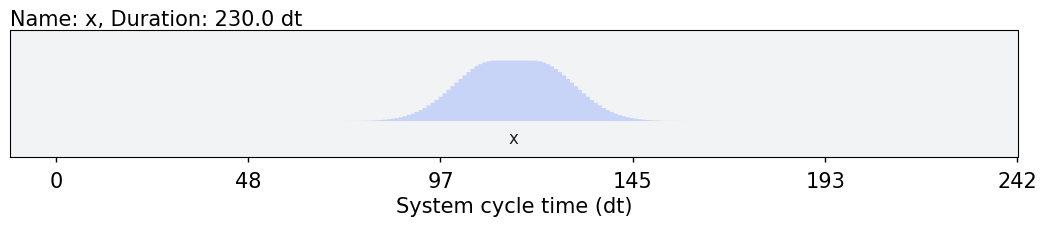

In [5]:
GaussianSquarePulseGate(230, 1, 10, 10, jax=True, name="x").pulse().draw()


In [6]:
%%time
initial_params = np.array([10, 10])
opt_results = minimize(fun=jit_grad_obj0, x0=initial_params, jac=True, method="BFGS")
print(opt_results.message)
print(f"Optimized Sigma is {opt_results.x[0]} and Width is {opt_results.x[1]}")
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))


Optimization terminated successfully.
Optimized Sigma is 516.3533359263823 and Width is 212.18372079511272
Number of function evaluations: 14
Function value: 1.7818772313216158e-07
CPU times: user 2.86 s, sys: 6.84 ms, total: 2.87 s
Wall time: 2.87 s


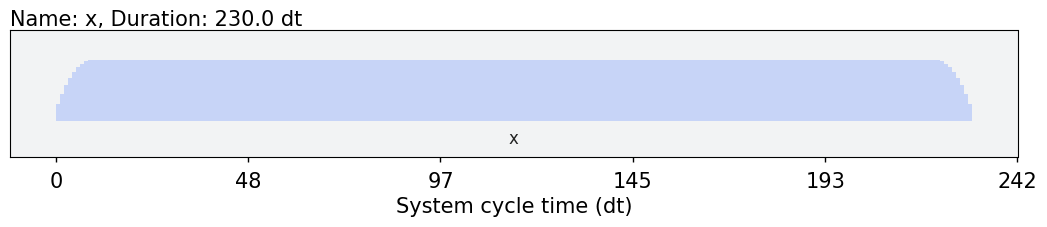

In [7]:
GaussianSquarePulseGate(230, 1, 516.3533359263823, 212.18372079511272, jax=True, name="x").pulse().draw()


In [55]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_manila")
config = backend.configuration()
dt = config.dt
props = backend.properties()
w = props.frequency(0)
solver_options = {"method": "DOP853"}
solver_options_jax = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}
dynamics_backend = DynamicsBackend.from_backend(
    backend=backend,
    subsystem_list=[0],
    solver_options=solver_options_jax
)


In [56]:
def build_pulse_gate(params):
    duration = 230
    amplitude = 1
    sigma, width = params
    return GaussianSquarePulseGate(duration, amplitude, sigma, width, jax=True, name="x")

def build_circuit(params):
    # return pulse.schedule(0, backend=backend, measured=True)
    return PulseCircuit.from_pulse(build_pulse_gate(params), backend, 0)

def objective1(params):
    circuit = build_circuit(params)
    result = dynamics_backend.run(
        run_input=circuit,
    ).result()
    target = {"0": 0, "1": 1024}
    fidelity = hellinger_fidelity(target, result.get_counts())
    return 1. - fidelity

jit_grad_obj1 = jit(value_and_grad(objective1))

initial_params = np.array([10., 10.])


In [57]:
build_circuit(initial_params).draw()


┌───┐┌─┐
  q: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

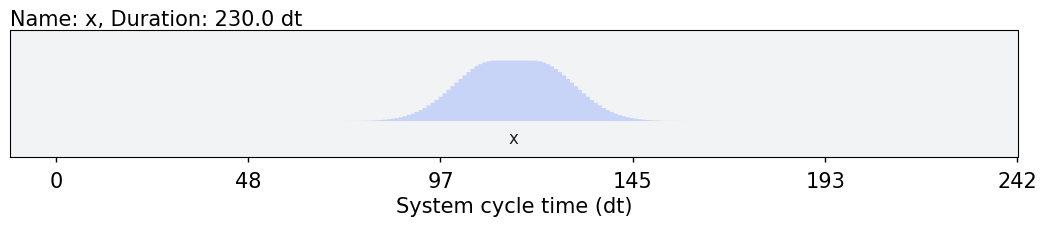

In [58]:
build_pulse_gate(initial_params).pulse().draw()

In [59]:
%%time
objective1(initial_params)


CPU times: user 623 ms, sys: 23.5 ms, total: 647 ms
Wall time: 651 ms


0.8046875

In [63]:
%%time
opt_results = minimize(fun=objective1, x0=initial_params, jac=False, method="Nelder-Mead")
print(opt_results.message)
print(f"Optimized Sigma is {opt_results.x[0]} and Width is {opt_results.x[1]}")
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))


Maximum number of function evaluations has been exceeded.
Optimized Sigma is 13.953078741523512 and Width is 11.581183076187841
Number of function evaluations: 400
Function value: 0.001953125
CPU times: user 3min 50s, sys: 7.05 s, total: 3min 57s
Wall time: 3min 52s


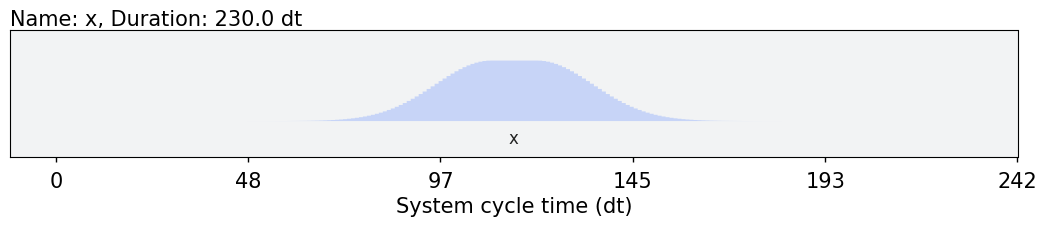

In [65]:
final_params = np.array([13.953078741523512, 11.581183076187841])
build_pulse_gate(final_params).pulse().draw()


In [66]:
%%time
result = dynamics_backend.run(build_circuit(final_params)).result()
print(result.get_counts())


{'0': 10, '1': 1014}
CPU times: user 571 ms, sys: 17.5 ms, total: 589 ms
Wall time: 578 ms
